In [551]:
# required libraries
# run only once per machine

# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install xgboost



# Predicting Movie Revenue (Classification)

This notebook goes over the steps involved in solving the problem of deciding what movie to recommend to customers, based on what revenue it can potential produce.

Broadly the steps taken are:
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Data EXploration and Visualization](#Data-Exploration-and-Visualization)
- [Feature Engineering](#Feature-Engineering)
- [Model Training and Evaluation](#Model-Training-and-Evaluation)

In [23]:
# import required libraries
import pandas as pd
from pandas import DataFrame
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
# import xgboost as xgb

## Data Import and Cleaning
In this section, some basic information about the data is gathered, such as the type of data in each column, the number of null values in each column, the format of data in each column. Then based on this information, we clean the data.

In [24]:
# import train data and show some basic information
movie_train = pd.read_csv("resources/data science case study/train.csv")
movie_train.info()

# import test data
test_movies = pd.read_csv("resources/data science case study/test.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2398 non-null   object 
 1   country             2400 non-null   object 
 2   genres              2400 non-null   object 
 3   language            2400 non-null   object 
 4   writer_count        2306 non-null   float64
 5   title_adaption      2400 non-null   bool   
 6   censor_rating       2362 non-null   object 
 7   release_date        2396 non-null   object 
 8   runtime             2400 non-null   object 
 9   dvd_release_date    2331 non-null   object 
 10  users_votes         2400 non-null   object 
 11  comments            1974 non-null   float64
 12  likes               1956 non-null   float64
 13  overall_views       2083 non-null   float64
 14  dislikes            1956 non-null   float64
 15  ratings_imdb        2400 non-null   object 
 16  rating

In [3]:
# view the first 5 rows of the training data
movie_train.head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3.0,True,G,11-Feb-05,68 min,24-May-05,...,NaN,NaN,NaN,6.4/10,80%,64/100,0,0,1,High
1,Yeh Jawaani Hai Deewani,India,"Comedy, Drama, Musical, Romance","Hindi, English, French",2.0,True,Not Rated,31-May-13,160 min,15-Jul-13,...,124.0,127528.0,12.0,7.1/10,67%,0,0,22,92,Low
2,Tae Guk Gi: The Brotherhood of War,South Korea,"Action, Drama, War",Korean,4.0,False,R,24-Sep-04,140 min,15-Feb-05,...,614.0,351123.0,18.0,8.1/10,80%,64/100,0,12,7,Low
3,"Book of Eli, The",USA,"Action, Adventure, Drama, Thriller",English,1.0,False,R,15-Jan-10,118 min,15-Jun-10,...,NaN,NaN,NaN,6.9/10,47%,53/100,0,3,16,High
4,Blind Dating,USA,"Comedy, Romance",English,1.0,False,PG-13,26-Apr-07,95 min,05-Feb-08,...,693.0,970306.0,36.0,6.1/10,25%,0,0,0,0,Low


In [15]:
# check for duplicate movie entries
movie_train.duplicated(subset='title').count()
movie_train['title'].isna().sum()

2

From the cells above, the following can be gleaned
1. There are a few null movie titles; these will have to be dropped
2. Some other columns have null values and different strategies will be adopted for how they may be addressed
3. Movie ratings appear as strings, these will have to be converted to floats
4. There 2400 entries.
5. The release date and dvd release dates are not in a datetime format
6. The runtime should be in numeric form as opposed to string
7. There are no duplicates in the data


In [16]:
# drop null titles
movie_train.dropna( subset=['title'],axis='index', inplace=True)
# there are now 2398 entries

In [18]:
# check the distribution for number of writers
movie_train['writer_count'].value_counts()

# most movies have one or two writers, fill the null values with 1
movie_train['writer_count'].fillna(1, inplace=True)

In [19]:
# The strategy employed for filling the null release dates and dvd_release dates is
# to fill either column from data from the other column. i.e fill release dates null values with dvd release dates
# and vice versa

def fill_releases(data: DataFrame, col_to_fill: str, fill_with: str) -> DataFrame:
    """Fills in one column of a dataframe with the data of another.

    Args:
        data (DataFrame): dataframe containing the data
        col_to_fill (str): the name of the column that needs filling
        fill_with (str): the name of the column to get data for filling

    Returns:
        DataFrame: dataframe containing the data
    """
    # locate the slice of the dataframe that needs to be filled
    missing = data.loc[data[col_to_fill].isna()]
    # locate the data to fill the missing columns with
    filler = missing[fill_with]
    # fill the missing columns with the filler data

    data.loc[data[col_to_fill].isna(), col_to_fill] = filler

    return data

In [26]:
missing = movie_train.loc[movie_train['release_date'].isna()]
filler = missing['dvd_release_date']
filler

215     19-Nov-12
1427    22-Mar-05
2002    31-May-11
2201    29-Mar-05
Name: dvd_release_date, dtype: object

In [559]:
# fill the release date column

movie_data = fill_releases(movie_train, 'release_date', 'dvd_release_date')

In [560]:
# fill the dvd_release date column
movie_data_2 = fill_releases(movie_data, 'dvd_release_date', 'release_date')

In [561]:
# check for where the null values are and the genres associated
# with them.
missing_rating = movie_data_2.loc[movie_data_2['censor_rating'].isna()]

# get the genres with the null values and save in a list
missing_genres = missing_rating['genres'].value_counts()
miss_gen = list(missing_genres.index)
miss_gen

['Drama',
 'Documentary',
 'Comedy',
 'Comedy, Drama',
 'Comedy, Romance',
 'Sci-Fi, Thriller',
 'Documentary, Biography, History',
 'Documentary, War',
 'Drama, Mystery, Thriller',
 'Animation, Action, Adventure, Family, Fantasy, Sci-Fi',
 'Documentary, History',
 'Drama, Romance',
 'Comedy, Drama, Music, Romance',
 'Documentary, Biography, Comedy, Drama, Family',
 'Comedy, Drama, Musical, Romance',
 'Comedy, Crime, Drama',
 'Drama, Sci-Fi',
 'Documentary, Drama',
 'Documentary, Music',
 'Documentary, Comedy, News',
 'Comedy, Drama, Crime',
 'Crime, Drama, Thriller',
 'Documentary, Biography, History, News',
 'Drama, War']

In [562]:
def filling_censorship(data: DataFrame, search_term):
    """Fills the censorship column with the top censor rating for
    that genre.

    Args:
        data (DataFrame): dataframe with censoring information
        search_term (str): type of genre search_term
    """
    try:
        # find the top censor rating for the specified genre
        top_rating = data.loc[data['genres'] == search_term]['censor_rating'].value_counts().index[0]
        data.loc[data['genres'] == search_term, 'censor_rating'] = top_rating
        
    except IndexError:
        # if the genre has only null values, then ignore and print the message
        print("No Entry found for search term: ", search_term)

    return data

In [563]:
# for each genre in this list of genres, fill censor rating
for entry in miss_gen:
    movie_filled = filling_censorship(movie_data_2, entry)

No Entry found for search term:  Animation, Action, Adventure, Family, Fantasy, Sci-Fi
No Entry found for search term:  Documentary, Biography, Comedy, Drama, Family
No Entry found for search term:  Documentary, Comedy, News
No Entry found for search term:  Comedy, Drama, Crime
No Entry found for search term:  Documentary, Biography, History, News


In [564]:
# there are some entries for which no censor rating is specified
# drop these entries

#drop null values from censorship rating data 
movie_filled.dropna(axis='index', subset='censor_rating', inplace=True)

In [565]:
# the likes, overall views, dislikes, and comments still contain some null values
# fill these with the median values
# to prevent high values from affecting the inputted values
movie_filled['likes'].fillna(movie_filled['likes'].median(), inplace=True)
movie_filled['comments'].fillna(movie_filled['comments'].median(), inplace=True)
movie_filled['overall_views'].fillna(movie_filled['overall_views'].median(), inplace=True)
movie_filled['dislikes'].fillna(movie_filled['dislikes'].median(), inplace=True)

In [566]:
# Make the runtime column into a an integer column
movie_filled['runtime'] = movie_filled['runtime'].apply(lambda x: int(x.split(sep=' ')[0]))

In [567]:
# convert the release date and dvd release date to datetime format

movie_filled['release_date'] = pd.to_datetime(movie_filled['release_date'])
movie_filled['dvd_release_date'] = pd.to_datetime(movie_filled['dvd_release_date'])


In [568]:
# convert all ratings to integers (imdb, metascore, etc)
movie_filled['ratings_imdb'] = movie_filled['ratings_imdb'].apply(lambda x: float(x.split(sep='/')[0]))
movie_filled['ratings_tomatoes'] = movie_filled['ratings_tomatoes'].apply(lambda x: int(re.search(r'\d+', x).group())/10)

In [569]:
# in the rating metacritic column there are too many zero entries
highest_value_count = movie_filled['ratings_metacritic'].value_counts()[[0]]
print(highest_value_count)

# drop the rating metacritic column
movie_filled.drop('ratings_metacritic', axis='columns', inplace=True)


0    112
Name: ratings_metacritic, dtype: int64


In [570]:
# convert the user votes feature to an integer
movie_filled['users_votes'] = movie_filled['users_votes'].apply(lambda x: int(x.replace(",", "")))

To Recap the cleaning section, to handle null values:
- We dropped some of the movie entries with no titles,
- Filled the writer count with 1, since most movies have a writer count of one
- Then we filled the release date with values from the DVD release date column and vice versa
- We filled the censorship rating columns with ratings for similar movies by genre,
- Then dropped moves for which there was no similar movie.
- We then filled the likes, comments, dislikes columns with median values.
- We converted the runtime, IMDB rating and Tomatoes rating columns to numbers
- Then converted the release date columns to datetime values and dropped the metacritic column because it had too many zeros.


## Data Exploration and Visualization

In this section, the data is explored to look for interesting patterns.
Visualization is also done to aid this process.
We check how features interact with each other and the target column.


In [571]:
# check for data imbalance
data_count = Counter(movie_filled['revenue_category'])
data_count.items()
# from here we see that the dataset is not imbalanced because the ratio between the two columns is close to one.

dict_items([('High', 1220), ('Low', 1173)])

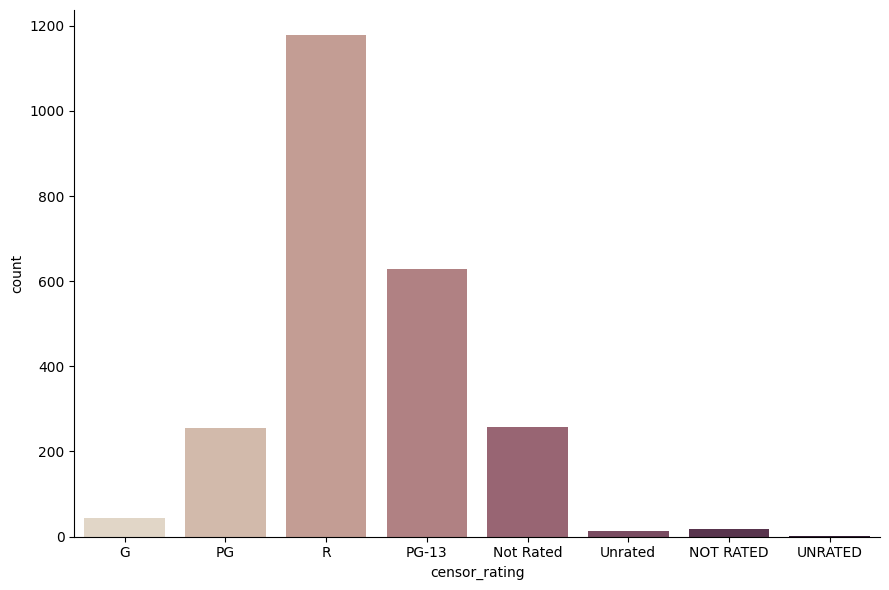

In [572]:
# Here we visualize the distribution of some of the features in the dataset
# such as censor_rating, runtime, ratings_imdb, ratings_tomatoes, user_votes
# plt.plot(movie_filled['censor_rating'].value_counts())
sns.catplot(x="censor_rating", kind="count", palette="ch:.25", data=movie_filled, height=6, aspect=1.5)



<AxesSubplot:xlabel='runtime', ylabel='Count'>

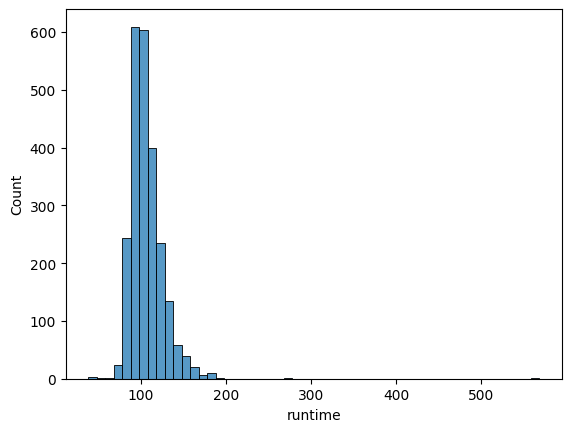

In [573]:
sns.histplot(data=movie_filled, x='runtime', binwidth=10)

<AxesSubplot:xlabel='ratings_tomatoes', ylabel='Count'>

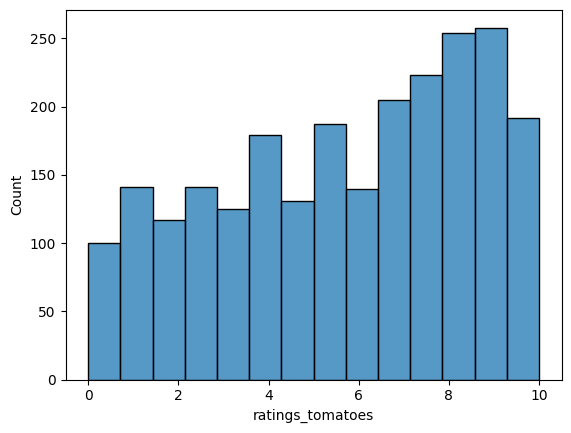

In [574]:
sns.histplot(data=movie_filled, x='ratings_tomatoes')

<AxesSubplot:xlabel='ratings_imdb', ylabel='Count'>

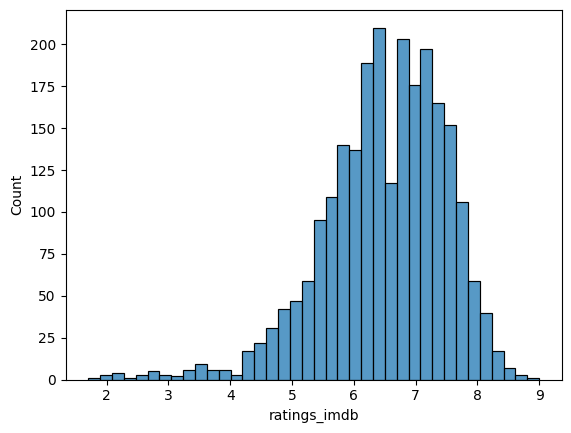

In [575]:
sns.histplot(data=movie_filled, x='ratings_imdb')

<AxesSubplot:xlabel='users_votes', ylabel='Count'>

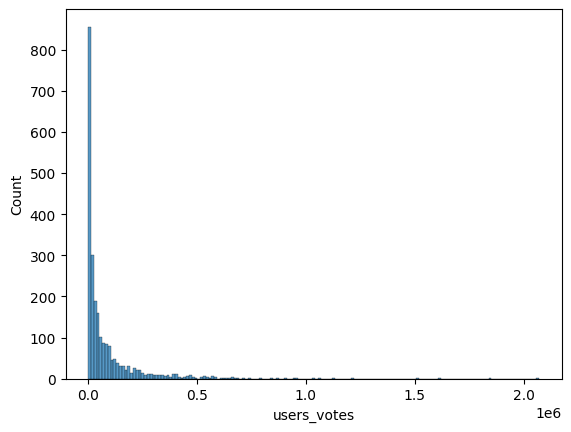

In [576]:
sns.histplot(data=movie_filled, x='users_votes')

From the plots above we see that:
1. Most censor rating in the data set is rated R.
2. There are some entries which are not rated/unrated, this suggests that the rating column needs to be further engineered
3. Most movies run for approximately 100 minutes, and there are some outliers which run for up 500 minutes.
4. The distribution of rating for IMDB and Tomatoes is left tailed with most ratings falling between 6 and 8, or 6 and 8 respectively
5. The distribution for the user votes is right tailed with most vote counts being under a million votes, with some movies achieving more than 500 thousand votes

Next we will see how these features relate to the revenue of the movie

<AxesSubplot:xlabel='censor_rating', ylabel='writer_count'>

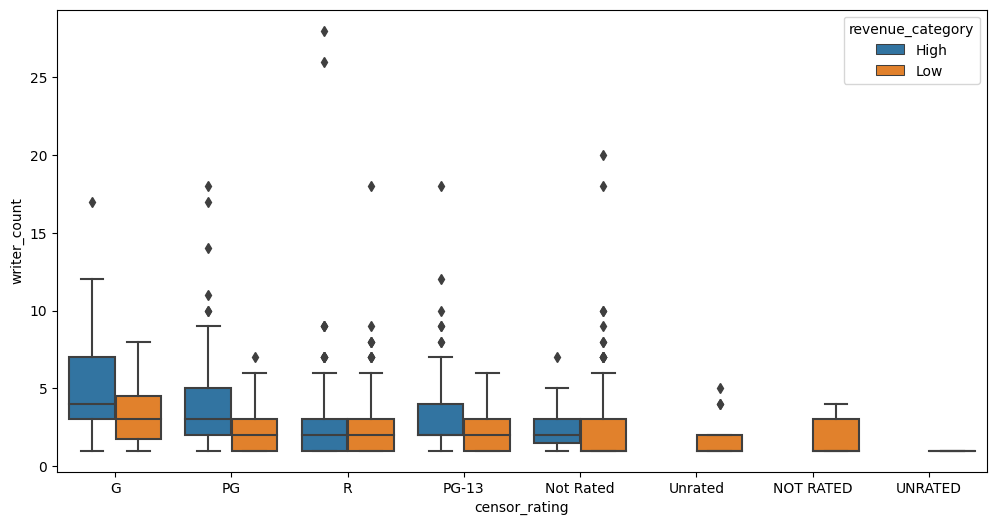

In [577]:
# make a boxplot of revenue, censor rating
plt.figure(figsize =(12,6))
sns.boxplot(x='censor_rating', y='writer_count', hue='revenue_category', data=movie_filled)

From the above plot, we see that the across genres, generally speaking, the having more writers leads to more revenue. However for the rated R movies, the number of writers in the movie does not affect revenue.

<AxesSubplot:xlabel='title_adaption', ylabel='runtime'>

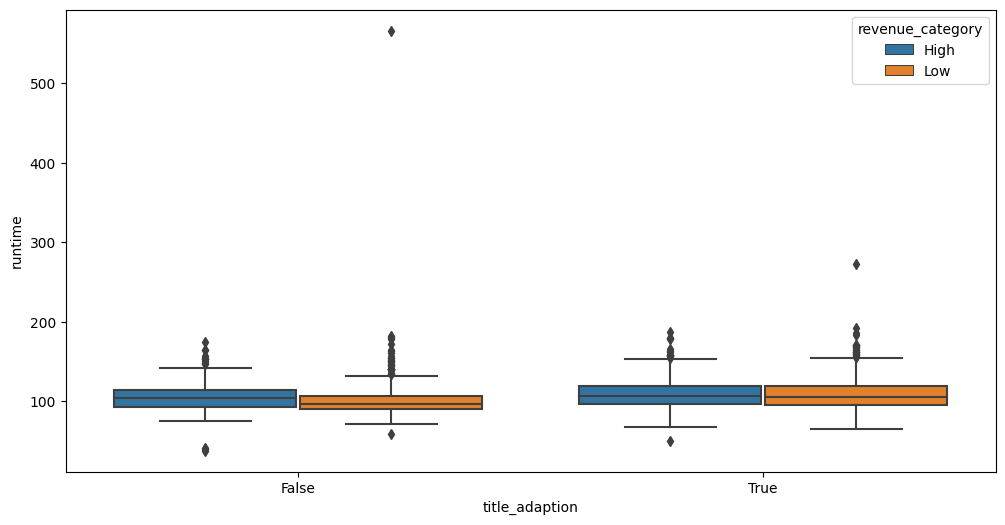

In [578]:
plt.figure(figsize =(12,6))
sns.boxplot(x='title_adaption', y='runtime', hue='revenue_category', data=movie_filled)

From the above plot we see that the runtime of the movie does not affect/correlate with the revenue generated.
Also the whether or not the movie was an adaptation did not really affect the revenue it generated.

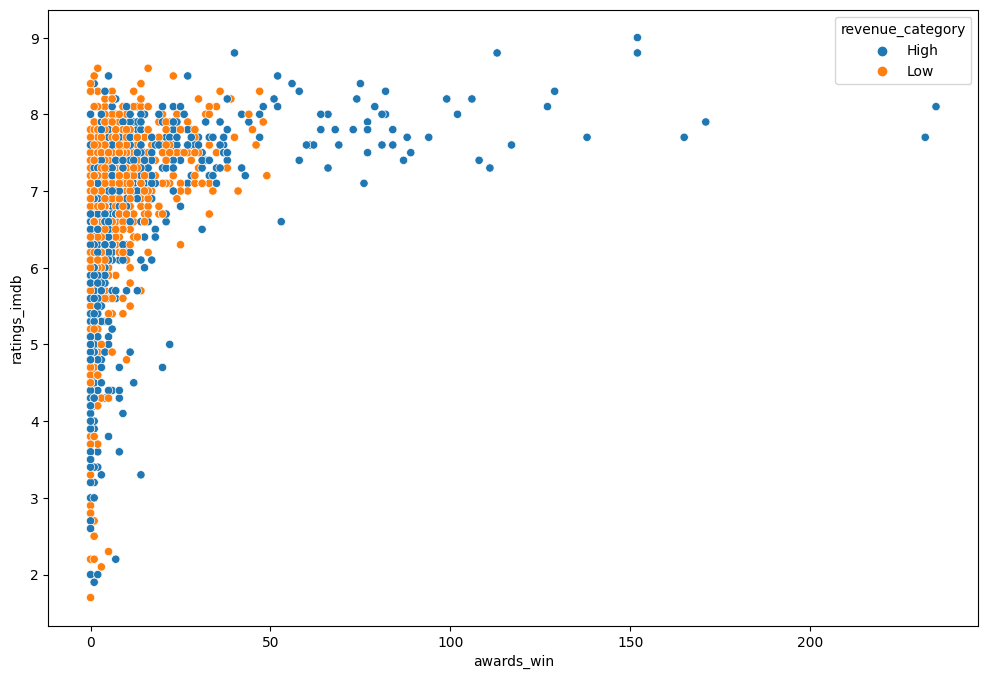

In [579]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=movie_filled.awards_win, y=movie_filled.ratings_imdb, hue=movie_filled['revenue_category'],)
plt.show()

In the above plot, we see that the low revenue movies tend to have high IMDB ratings, but to certain about a movie's performance, we need to also look at it's awards win. For the movies with a high IMDB rating and high number of awards, they are high revenue movies. It is a very good indicator
Next, we will see how the numerical features corelate to the revenue category.
To achieve this, we will encode the revenue category into 1, 0

In [580]:
# use the label encoder to generate the labels.
# High = 0
# Low = 1

lb_enc = LabelEncoder()
movie_filled['revenue_category'] = lb_enc.fit_transform(movie_filled.revenue_category)

<AxesSubplot:>

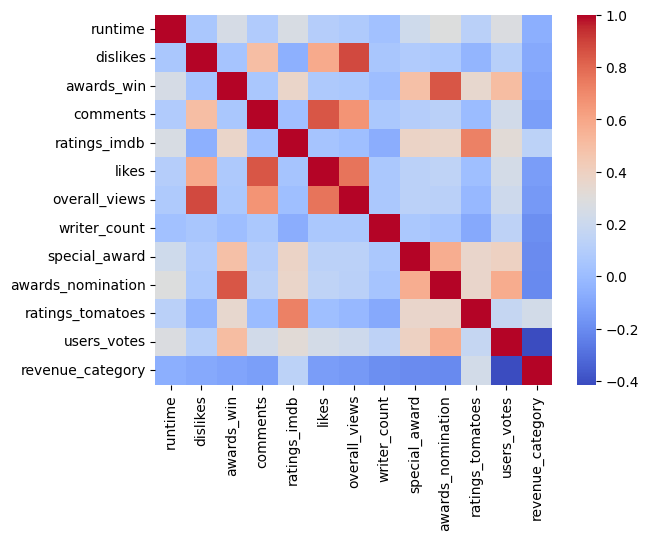

In [581]:
# slice out the numerical columns
num_features = ['writer_count', 'runtime', 'users_votes', 'comments', 'likes', 'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes', 'special_award', 'awards_win', 'awards_nomination', 'revenue_category']

movie_nums = movie_filled[num_features]
movie_corr = movie_nums.corr()
sorted_co = movie_corr['revenue_category'].abs().sort_values()

movie_co = movie_data[sorted_co.index].corr()
sns.heatmap(movie_co,cmap='coolwarm')


From the above corelation plot, we can see that many of the features corelate with the revenue category  albeit weakly.
Writer_count, special_award, award_nomination, user_votes are the columns that corelate the most with the revenue category, with user votes the most strongly correlated.
Also, we can see that some features corelate with each other. Examples are:
1. Awards_nomination and awards_win
2. Overall_views and Dislikes
3. Likes and comments
4. Likes and Overall_views
5. Comments and Likes

To resolve this, the overall_views and awards_nomination will be used a surrogate for the other columns.

## Feature Engineering
In this section the features are prepared so that they can be processed by machine learning algorithms, this may involve, encoding the categorical columns, dropping some redundant columns.
Changing some of the features so that they contain more information

In [582]:
# drop the categorical columns except genres, and language
movie_filled.drop(['title', 'country'], axis='columns', inplace=True)


In [583]:
def bin_dates(my_date):
    """Bin dates into categories describing what time of year they are released

    Args:
        my_date (_type_): datetime object

    Returns:
        category: time of year
    """
    month = my_date.month
    if month in [6, 7,]:
        return "Summer"
    elif month in [1, 12]:
        return "Christmas"
    elif month in [3,4]:
        return "Easter"
    else:
        return "Rest of year"


In [584]:
# bin the release date into different movie seasons
movie_filled['release_date'] = movie_filled['release_date'].apply(bin_dates)

In [585]:
# drop the dvd release date column
movie_filled.drop('dvd_release_date', axis='columns', inplace=True)


In [586]:
# drop multi corelated columns
movie_filled.drop(['comments', 'likes', 'dislikes', 'awards_nomination'], axis='columns', inplace=True)


In [587]:
# clean the censorship rating column by unifying all the unrated movies
movie_filled['censor_rating'].unique()
similar_entries = ['Not Rated', 'Unrated', 'NOT RATED',
       'UNRATED']

In [588]:
# congregate all the unrated entries
movie_filled.loc[movie_filled['censor_rating'] == 'Unrated', 'censor_rating'] = 'Not Rated'

movie_filled.loc[movie_filled['censor_rating'] == 'NOT RATED', 'censor_rating'] = 'Not Rated'

movie_filled.loc[movie_filled['censor_rating'] == 'UNRATED', 'censor_rating'] = 'Not Rated'

## Model Training and Evaluation
Training a decision tree model and an XGBoost model, because these models are typically explainable because they are based on trees. The model is evaluated using accuracy and Area Under the Curve for the Receiver Operating Characteristics Curve (AUCROC)

In [589]:
# make dummy_genres columns
cleaned_genres = movie_data_2.set_index('language').genres.str.split(',', expand=True).stack()
dummy_genres = pd.get_dummies(cleaned_genres, prefix='g').groupby(level=0).sum()

# merge this dataframe into the movie dataframe
movie_df = pd.merge(movie_filled, dummy_genres, on='language', how='inner')

In [590]:
# Emcode the remain categorical columns

final_df = pd.get_dummies(movie_df, columns=['censor_rating', 'release_date'], drop_first=True)


In [591]:
# drop the genres and language columns
final_df.drop(['genres', 'language'], axis='columns', inplace=True)

In [592]:
# check the performance of a decision tree model on the data
X = final_df.drop('revenue_category', axis='columns')
y = final_df['revenue_category']


clf = DecisionTreeClassifier(random_state=22)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
np.mean(scores)*100

79.40016247237534

The AUCROC represents how well a model is able to distinguish between the classes present in the target of data set. Compared to accuracy it is not affected to the distribution of the class, or the threshold used by the algorithm. 

The AUCROC uses the predicted probability of a sample belonging to a class, to determine how well a model is able to perform. It is measured between 0 and 1, where 1 is a perfect model and 0.5 is a no-skill model which no better than random chance. 

In [593]:
# check the roc for this model
roc_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
np.mean(roc_scores)

0.7939448305056954

In [594]:
# Improve the performance of the model by searching the model space wih a grid search.
# search using the criterion and max_depth
# score using the AUCROC
parameters = {'criterion':('gini', 'log_loss', 'entropy'),
                'max_depth':[5, 10],
                'random_state':[22]}
clf_grid = GridSearchCV(clf, parameters, scoring='roc_auc')
clf_grid.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=22),
             param_grid={'criterion': ('gini', 'log_loss', 'entropy'),
                         'max_depth': [5, 10], 'random_state': [22]},
             scoring='roc_auc')

In [595]:
# get the parameters for the best model
clf_grid.best_params_

{'criterion': 'log_loss', 'max_depth': 5, 'random_state': 22}

In [596]:
# use the parameters and check if scores improve
clf_opt = DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=22)
scores = cross_val_score(clf_opt, X, y, cv=5, scoring='accuracy')
np.mean(scores)*100

# we see that the accuracy has increased from 79% to 82%


82.32641224307964

In [597]:
# use the parameters and check if scores improve
# clf_opt = DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=22)
scores = cross_val_score(clf_opt, X, y, cv=5, scoring='roc_auc')
np.mean(scores)


# we see that the accuracy has increased from 79% to 82%, and AUCROC from 0.79 to 0.89


0.8936323146682407

Here we see that the performance of a decision tree model is significantly increased by doing some hyperparameter tuning. Raising the Accuracy from 79% to 82% and AUCROC from 0.79 to 0.89.
Consequently we train a XGboost model which is an ensemble of trees

In [598]:
# Here we can check what features are important to the decision tree model
clf_opt.fit(X,y)
feat_imp = clf_opt.feature_importances_

important = []
train_columns = list(X.columns)

for entry in zip(train_columns, feat_imp):
    if entry[1] > 0:
        important.append(entry)

important_feat_df = pd.DataFrame(important, columns=['feature', 'importance'])
important_feat_df.sort_values(by=['importance'], ascending=False)

,feature,importance
1,users_votes,0.700679
3,ratings_imdb,0.128335
4,ratings_tomatoes,0.038577
0,runtime,0.025137
9,censor_rating_PG,0.020924
11,censor_rating_R,0.020423
8,censor_rating_Not Rated,0.020135
7,g_ Thriller,0.015724
10,censor_rating_PG-13,0.015376
2,overall_views,0.005249


From the dataframe, we see that the most important features are the user_votes, ratings_imdb, ratings_tomatoes, runtime, censor_rating (PG, R, Not_rated) in this order.

In [599]:
# try out an xgboost model

data_dmatrix = xgb.DMatrix(data=X,label=y)

xgb_params = {'objective':'binary:logistic',
            'learning_rate': 0.1,
            'max_depth': 5, 'alpha': 10}
# scores = cross_val_score(xgb_clf, X, y, cv=5, scoring='accuracy')
# np.mean(scores)*100
cv_results = xgb.cv(dtrain=data_dmatrix, params=xgb_params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=123)
cv_results['test-auc-mean'].tail(1)

49    0.931018
Name: test-auc-mean, dtype: float64

Here we see the XGBoost model producing an AUCROC of 0.93, as compared to the optimized Decision Tree model which produced an auc score of 0.89. We will use to the XGBoost model on the test dataset, but it is important to note that the xgboost model may have overfit the data, this might be further investigated later.
Using the XGBoost model we can also find out which features it considered important.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

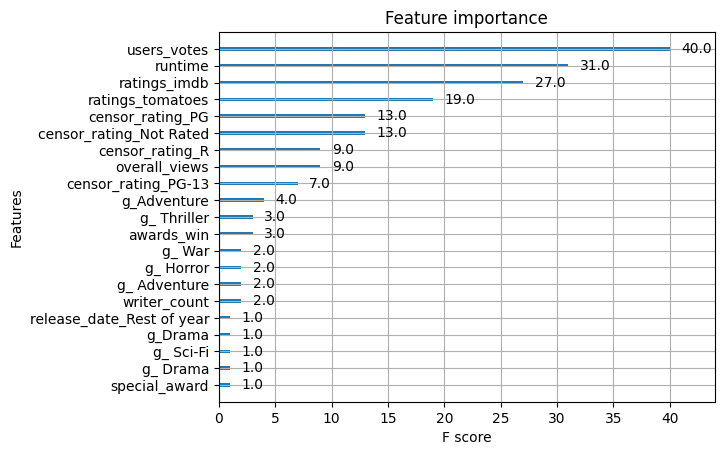

In [600]:
xgb_clf = xgb.train(params=xgb_params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xgb_clf)

## Reporting Test Results
In this section the trained model is used to predict the type of revenue a movie in the data set might achieve.
To do this, we need to check the test data for any null values, then re-engineer the data so that it has the same structure as the training data. This will enable predictions to be made

In [601]:
test_movie_list = test_movies['title'].to_list()
test_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               600 non-null    object 
 1   country             600 non-null    object 
 2   genres              600 non-null    object 
 3   language            600 non-null    object 
 4   writer_count        571 non-null    float64
 5   title_adaption      600 non-null    bool   
 6   censor_rating       584 non-null    object 
 7   release_date        598 non-null    object 
 8   runtime             600 non-null    object 
 9   dvd_release_date    582 non-null    object 
 10  users_votes         600 non-null    object 
 11  comments            476 non-null    float64
 12  likes               477 non-null    float64
 13  overall_views       507 non-null    float64
 14  dislikes            477 non-null    float64
 15  ratings_imdb        600 non-null    object 
 16  ratings_

Observations
Of the columns that will be kept,
- Writer count has some null entries
- censor rating has some null entries
- release_date has some null entries
- overall views has some null entries

In [602]:
# the writer count will be filled with 1
test_movies['writer_count'].fillna(1, inplace=True)

# fill the release date with the dvd release date
test_data = fill_releases(test_movies, 'release_date', 'dvd_release_date')

In [603]:
# fill the censorship_rating feature 

# check for where the null values are and the genres associated
# with them.
test_rating = test_data.loc[test_data['censor_rating'].isna()]

# get the genres with the null values and save in a list
test_genres = test_rating['genres'].value_counts()
test_miss_gen = list(test_genres.index)
test_miss_gen

for entry in test_miss_gen:
    test_filled = filling_censorship(test_data, entry)

No Entry found for search term:  Animation, Comedy, Family
No Entry found for search term:  Action, Comedy, Romance
No Entry found for search term:  Comedy, Crime, Mystery, Thriller
No Entry found for search term:  Drama, Fantasy, Horror


In [604]:
# fill any unfilled rows with unrated
test_filled.loc[test_filled['censor_rating'].isna(), 'censor_rating'] = 'Not Rated'


# make the runtime an integer
test_filled['runtime'] = test_filled['runtime'].apply(lambda x: int(x.split(sep=' ')[0]))

# convert the release date feature to datetime
test_filled['release_date'] = pd.to_datetime(test_filled['release_date'])



In [605]:
# convert all ratings to integers (imdb, metascore, etc)
test_filled['ratings_imdb'] = test_filled['ratings_imdb'].apply(lambda x: float(x.split(sep='/')[0]))
test_filled['ratings_tomatoes'] = test_filled['ratings_tomatoes'].apply(lambda x: int(re.search(r'\d+', x).group())/10)

# make the user votes a numerical feature
test_filled['users_votes'] = test_filled['users_votes'].apply(lambda x: int(x.replace(",", "")))

In [606]:
cols_to_retain = ['genres', 'language', 'writer_count', 'title_adaption', 'censor_rating',
       'release_date', 'runtime', 'users_votes', 'overall_views',
       'ratings_imdb', 'ratings_tomatoes', 'special_award', 'awards_win'
       ]

# testing_data = test_filled[cols_to_retain]
# fill the overall views and bin the release dates
test_filled['overall_views'].fillna(test_filled['overall_views'].median(), inplace=True)
test_filled['release_date'] = test_filled['release_date'].apply(bin_dates)

In [607]:
# congregate all the unrated entries
test_filled.loc[test_filled['censor_rating'] == 'Unrated', 'censor_rating'] = 'Not Rated'

test_filled.loc[test_filled['censor_rating'] == 'NOT RATED', 'censor_rating'] = 'Not Rated'

test_filled.loc[test_filled['censor_rating'] == 'UNRATED', 'censor_rating'] = 'Not Rated'

In [608]:
# test_filled.drop(columns=['title'], axis='columns')
testing_data = test_filled[cols_to_retain]

test_cleaned_genres = test_data.set_index('language').genres.str.split(',', expand=True).stack()
test_genres = pd.get_dummies(test_cleaned_genres, prefix='g').groupby(level=0).sum()

# merge this dataframe into the movie dataframe
testing_df = pd.merge(testing_data, test_genres, on='language', how='inner')


In [609]:
# make dummy features with censor_rating and release date
final_test_df = pd.get_dummies(testing_df, columns=['censor_rating', 'release_date'], drop_first=True)
final_test_df.drop(['genres', 'language'], axis='columns', inplace=True)

In [610]:
# drop the g_Music column
final_test_df.drop('g_Music', axis='columns', inplace=True)

In [611]:
# g_ Documentary, g_ Short, g_ Animation, g_Sci-Fi, g_Musical, g_ Film-Noir, g_Mystery
final_test_df['g_ Documentary'] = 0
final_test_df['g_ Short'] = 0
final_test_df['g_ Animation'] = 0
final_test_df['g_Sci-Fi'] = 0
final_test_df['g_Musical'] = 0
final_test_df['g_ Film-Noir'] = 0
final_test_df['g_Mystery'] = 0

In [612]:
# make sure that the data is in the correct format for testing
train_X_cols = list(X.columns)
test_final_df = final_test_df[train_X_cols]

In [613]:
# predicting the values for the test data
test_matrix = xgb.DMatrix(data=final_test_df)

preds = xgb_clf.predict(data=test_matrix, validate_features=False)

# round predictions
predictions = [round(x, 0) for x in preds]


In [614]:
def add_revenue(x):
    """Converts the predicitons from numbers to Words (High or Low).
    Where High is 0, and Low is 1
    """
    if x != 0:
        return "Low"
    else:
        return "High"


In [615]:
# convert the predicitions to High / Low
final_prediction = [add_revenue(a) for a in predictions]

In [616]:
submission_df = pd.DataFrame(zip(test_movie_list, final_prediction), columns=['title', 'revenue_category'])
submission_df.head()

,title,revenue_category
0,Delhi-6,Low
1,Before I Disappear,Low
2,"Good Year, A",Low
3,Brüno,Low
4,How to Lose a Guy in 10 Days,High


In [617]:
# write submission to file
submission_df.to_csv("prediction_sub.csv", index=False)

In [46]:
def fibonacci(num):
        if len(num) == 0:
            return 0
        else:
            return num.pop(0) + fibonacci(num)



In [3]:
def quicksort(listt):
    left= []
    right = []
    middle = []
    if len(listt) > 1:
        pivot = listt[0]
        for i in listt:
            if i < pivot:
                left.append(i)
            elif i== pivot:
                middle.append(i)
            elif i > pivot:
                right.append(i)
        return quicksort(left) + middle + quicksort(right)

    else:
        return listt
            

In [6]:
num= quicksort([1, 7, 4, 1, 10, 9, -2])
print(num)

[-2, 1, 1, 4, 7, 9, 10]


In [44]:
listt= [1,2,4,5,5]
print(listt)
listt.pop(0)
print(listt)


[1, 2, 4, 5, 5]
[2, 4, 5, 5]
